In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [25]:
train_dir = "cassavaleafdata/train"
val_dir = "cassavaleafdata/validation"
test_dir = "cassavaleafdata/test"


train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [26]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds = datasets.ImageFolder(val_dir, transform=eval_tf)
test_ds = datasets.ImageFolder(test_dir, transform=eval_tf)


print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

Classes: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
class_to_idx: {'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}


In [27]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [28]:
images, labels = next(iter(train_loader))
print(images.shape)   # (B, 3, 150, 150)
print(labels.shape)   # (B,)
print(labels[:10])

torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([3, 0, 3, 3, 2, 3, 0, 4, 1, 1])


In [24]:
# Debug: Kiểm tra kích thước từ train_loader
images_check, labels_check = next(iter(train_loader))
print(f"Images shape from train_loader: {images_check.shape}")

# Test thử qua model
test_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding="same"),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
)

with torch.no_grad():
    test_output = test_model(images_check)
    print(f"Output shape after flatten: {test_output.shape}")

Images shape from train_loader: torch.Size([64, 3, 224, 224])
Output shape after flatten: torch.Size([64, 46656])


In [29]:
class LeNetCNN:
    def __init__(self, output_dim=5, lr=1e-3, epochs=2):
        # Input: (B, 3, 224, 224) -> sau flatten: 16*54*54 = 46656
        self.model = nn.Sequential(
            # Conv block 1
            nn.Conv2d(3, 6, kernel_size=5, padding="same"),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Conv block 2
            nn.Conv2d(6, 16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Flatten + MLP head
            nn.Flatten(),
            nn.Linear(16 * 54 * 54, 120),
            nn.Linear(120, 84),
            nn.Linear(84, output_dim)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.list_loss_train = []
        self.list_loss_val = []
        self.list_acc_train = []
        self.list_acc_val = []

    def train(self, train_loader, val_loader):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Training LeNetCNN on {device}")
        self.model.to(device)

        for epoch in range(self.epochs):
            # === Train phase ===
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct / total

            # === Validation phase ===
            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total

            self.list_loss_train.append(train_loss)
            self.list_loss_val.append(val_loss)
            self.list_acc_train.append(train_acc)
            self.list_acc_val.append(val_acc)

            print(f'Epoch [{epoch+1}/{self.epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    def evaluate(self, test_loader):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        self.model.eval()
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        return accuracy

In [30]:
class MLP:
    def __init__(self, input_dim, output_dim=5, lr=0.01, epochs=2):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.list_loss_train = []
        self.list_loss_val = []
        self.list_acc_train = []
        self.list_acc_val = []

    def train(self, train_loader, val_loader):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Training MLP on {device}")
        self.model.to(device)

        for epoch in range(self.epochs):
            # === Train phase ===
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                # Flatten images for MLP: (B, 3, 150, 150) -> (B, 3*150*150)
                images = images.view(images.size(0), -1)
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct / total

            # === Validation phase ===
            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    # Flatten images for MLP
                    images = images.view(images.size(0), -1)
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total

            self.list_loss_train.append(train_loss)
            self.list_loss_val.append(val_loss)
            self.list_acc_train.append(train_acc)
            self.list_acc_val.append(val_acc)

            print(f'Epoch [{epoch+1}/{self.epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    def evaluate(self, test_loader):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        self.model.eval()
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                # Flatten images for MLP
                images = images.view(images.size(0), -1)
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        return accuracy

In [ ]:
# Train model 1: LeNetCNN
print("=" * 50)
print("Training LeNetCNN Model")
print("=" * 50)
model1 = LeNetCNN(output_dim=5, lr=1e-3, epochs=10)
model1.train(train_loader, val_loader)

Training LeNetCNN Model
Training LeNetCNN on cpu
Epoch [1/2], Train Loss: 1.5431, Train Acc: 45.08%, Val Loss: 1.2677, Val Acc: 51.35%
Epoch [2/2], Train Loss: 1.2452, Train Acc: 50.65%, Val Loss: 1.2656, Val Acc: 52.09%


In [ ]:
# Train model 2: MLP
print("\n" + "=" * 50)
print("Training MLP Model")
print("=" * 50)
model2 = MLP(input_dim=3*224*224, output_dim=5, lr=0.01, epochs = 10)
model2.train(train_loader, val_loader)


Training MLP Model
Training MLP on cpu
Epoch [1/10], Train Loss: 1.3609, Train Acc: 46.99%, Val Loss: 1.3773, Val Acc: 46.96%
Epoch [2/10], Train Loss: 1.3429, Train Acc: 47.05%, Val Loss: 1.3569, Val Acc: 46.96%
Epoch [3/10], Train Loss: 1.3352, Train Acc: 47.19%, Val Loss: 1.3458, Val Acc: 47.70%
Epoch [4/10], Train Loss: 1.3216, Train Acc: 48.02%, Val Loss: 1.3507, Val Acc: 49.76%
Epoch [5/10], Train Loss: 1.3179, Train Acc: 48.09%, Val Loss: 1.3892, Val Acc: 42.35%
Epoch [6/10], Train Loss: 1.3056, Train Acc: 48.50%, Val Loss: 1.3359, Val Acc: 50.56%
Epoch [7/10], Train Loss: 1.2951, Train Acc: 48.69%, Val Loss: 1.3131, Val Acc: 48.97%


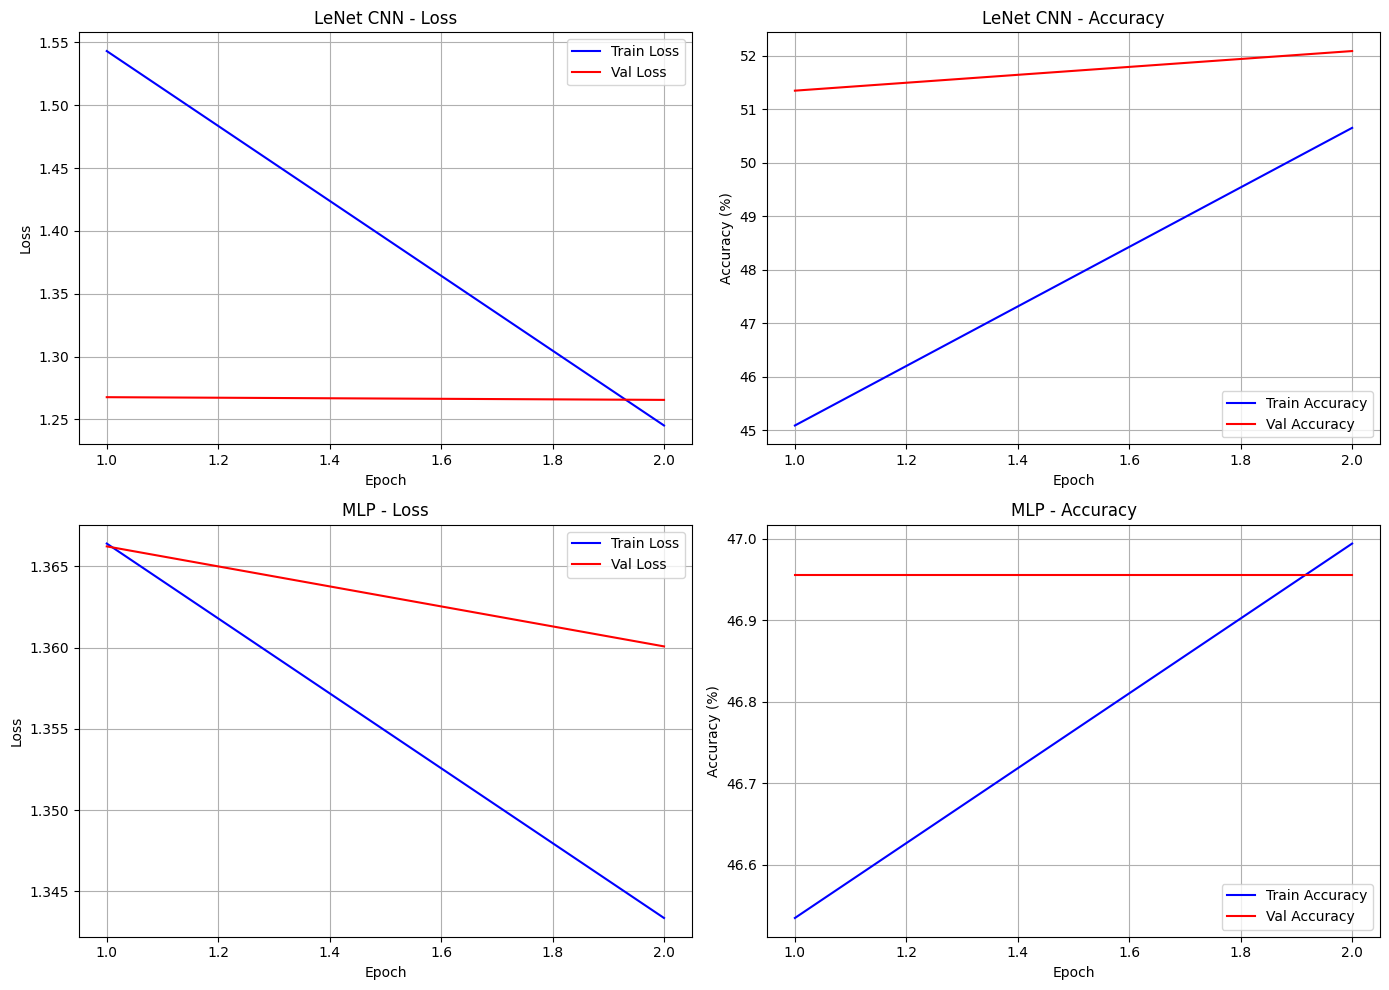

In [33]:
# Visualize training history - So sánh 2 models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs1 = range(1, len(model1.list_loss_train) + 1)
epochs2 = range(1, len(model2.list_loss_train) + 1)

# Plot Loss - LeNetCNN
axes[0, 0].plot(epochs1, model1.list_loss_train, 'b-', label='Train Loss')
axes[0, 0].plot(epochs1, model1.list_loss_val, 'r-', label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('LeNet CNN - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Accuracy - LeNetCNN
axes[0, 1].plot(epochs1, model1.list_acc_train, 'b-', label='Train Accuracy')
axes[0, 1].plot(epochs1, model1.list_acc_val, 'r-', label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('LeNet CNN - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Loss - MLP
axes[1, 0].plot(epochs2, model2.list_loss_train, 'b-', label='Train Loss')
axes[1, 0].plot(epochs2, model2.list_loss_val, 'r-', label='Val Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('MLP - Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Accuracy - MLP
axes[1, 1].plot(epochs2, model2.list_acc_train, 'b-', label='Train Accuracy')
axes[1, 1].plot(epochs2, model2.list_acc_val, 'r-', label='Val Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('MLP - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [34]:
# Evaluate trên test set
print("\n" + "=" * 50)
print("Evaluating on Test Set")
print("=" * 50)
print("\nLeNetCNN Model:")
acc1 = model1.evaluate(test_loader)

print("\nMLP Model:")
acc2 = model2.evaluate(test_loader)

print("\n" + "=" * 50)
print(f"Summary:")
print(f"LeNetCNN Test Accuracy: {acc1:.2f}%")
print(f"MLP Test Accuracy: {acc2:.2f}%")
print("=" * 50)


Evaluating on Test Set

LeNetCNN Model:
Test Accuracy: 53.16%

MLP Model:
Test Accuracy: 47.00%

Summary:
LeNetCNN Test Accuracy: 53.16%
MLP Test Accuracy: 47.00%


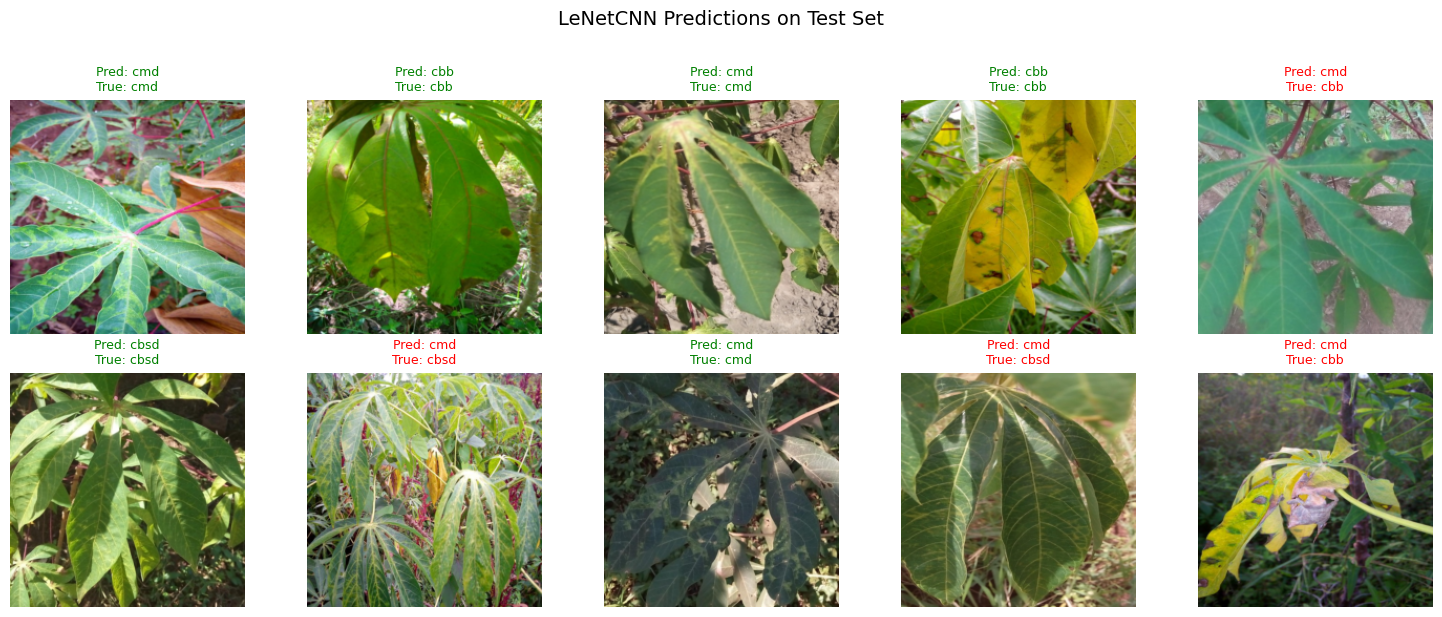

In [35]:
# Visualize một số predictions từ test set
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.model.eval()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
class_names = train_ds.classes

# Lấy 10 ảnh random từ test set
test_samples = random.sample(range(len(test_ds)), 10)

with torch.no_grad():
    for idx, sample_idx in enumerate(test_samples):
        img, true_label = test_ds[sample_idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        output = model1.model(img_tensor)
        _, predicted = torch.max(output, 1)
        
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img.permute(1, 2, 0))
        
        pred_class = class_names[predicted.item()]
        true_class = class_names[true_label]
        color = 'green' if predicted.item() == true_label else 'red'
        
        ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}', color=color, fontsize=9)
        ax.axis('off')

plt.suptitle('LeNetCNN Predictions on Test Set', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()